In [2]:
%config Completer.use_jedi = False # use autocompletion

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
# import PyCOCO tools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

setup_logger()

<Logger detectron2 (DEBUG)>

# Loading the train dataframe¶

In [3]:
df = pd.read_csv('sartorius-cell-instance-segmentation/train.csv')
df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

# Function that decodes rle (for this comp) to a binary mask

In [4]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

# Minor Sanity Check

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


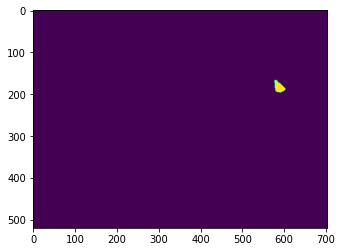

In [5]:
rle = df.loc[0, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

# Function that builds the .json file

In [6]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

def annotate(idx, row, cat_ids):
        mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
        c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
        c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
        area = maskUtils.area(c_rle).item() # calculating the area
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
        return annotation
    
def coco_structure(df, workers = 4):
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

# Split df according to class and prepare train and val json for each class.

In [7]:
import json,itertools

np.random.seed(42)

def split_df(df, thresh):
    all_ids = df.id.unique()
    np.random.shuffle(all_ids)
    thresh = int(all_ids.shape[0]*0.8) + 1

    train_df = df[df.id.isin(all_ids[:thresh])]
    val_df = df[df.id.isin(all_ids[thresh:])]

    train = coco_structure(train_df)
    val = coco_structure(val_df)
    
    return train, val

# df_c0 = df[df.cell_type == 'shsy5y']
# df_c1 = df[df.cell_type == 'astro']
# df_c2 = df[df.cell_type == 'cort']

train, val = split_df(df, 0.8)
# train_c0, val_c0 = split_df(df_c0, 0.8)
# train_c1, val_c1 = split_df(df_c1, 0.8)
# train_c2, val_c2 = split_df(df_c2, 0.8)

  0%|          | 0/61792 [00:00<?, ?it/s]

  0%|          | 0/11793 [00:00<?, ?it/s]

In [9]:
with open('sartorius-cell-instance-segmentation-coco/annotations_train.json', 'w+', encoding='utf-8') as f:
    json.dump(train, f, ensure_ascii=True, indent=4)
with open('sartorius-cell-instance-segmentation-coco/annotations_val.json', 'w+', encoding='utf-8') as f:
    json.dump(val, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_train_c0.json', 'w+', encoding='utf-8') as f:
#     json.dump(train_c0, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val_c0.json', 'w+', encoding='utf-8') as f:
#     json.dump(val_c0, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_train_c1.json', 'w+', encoding='utf-8') as f:
#     json.dump(train_c1, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val_c1.json', 'w+', encoding='utf-8') as f:
#     json.dump(val_c1, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_train_c2.json', 'w+', encoding='utf-8') as f:
#     json.dump(train_c2, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val_c2.json', 'w+', encoding='utf-8') as f:
#     json.dump(val_c2, f, ensure_ascii=True, indent=4)

# Sanity check

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


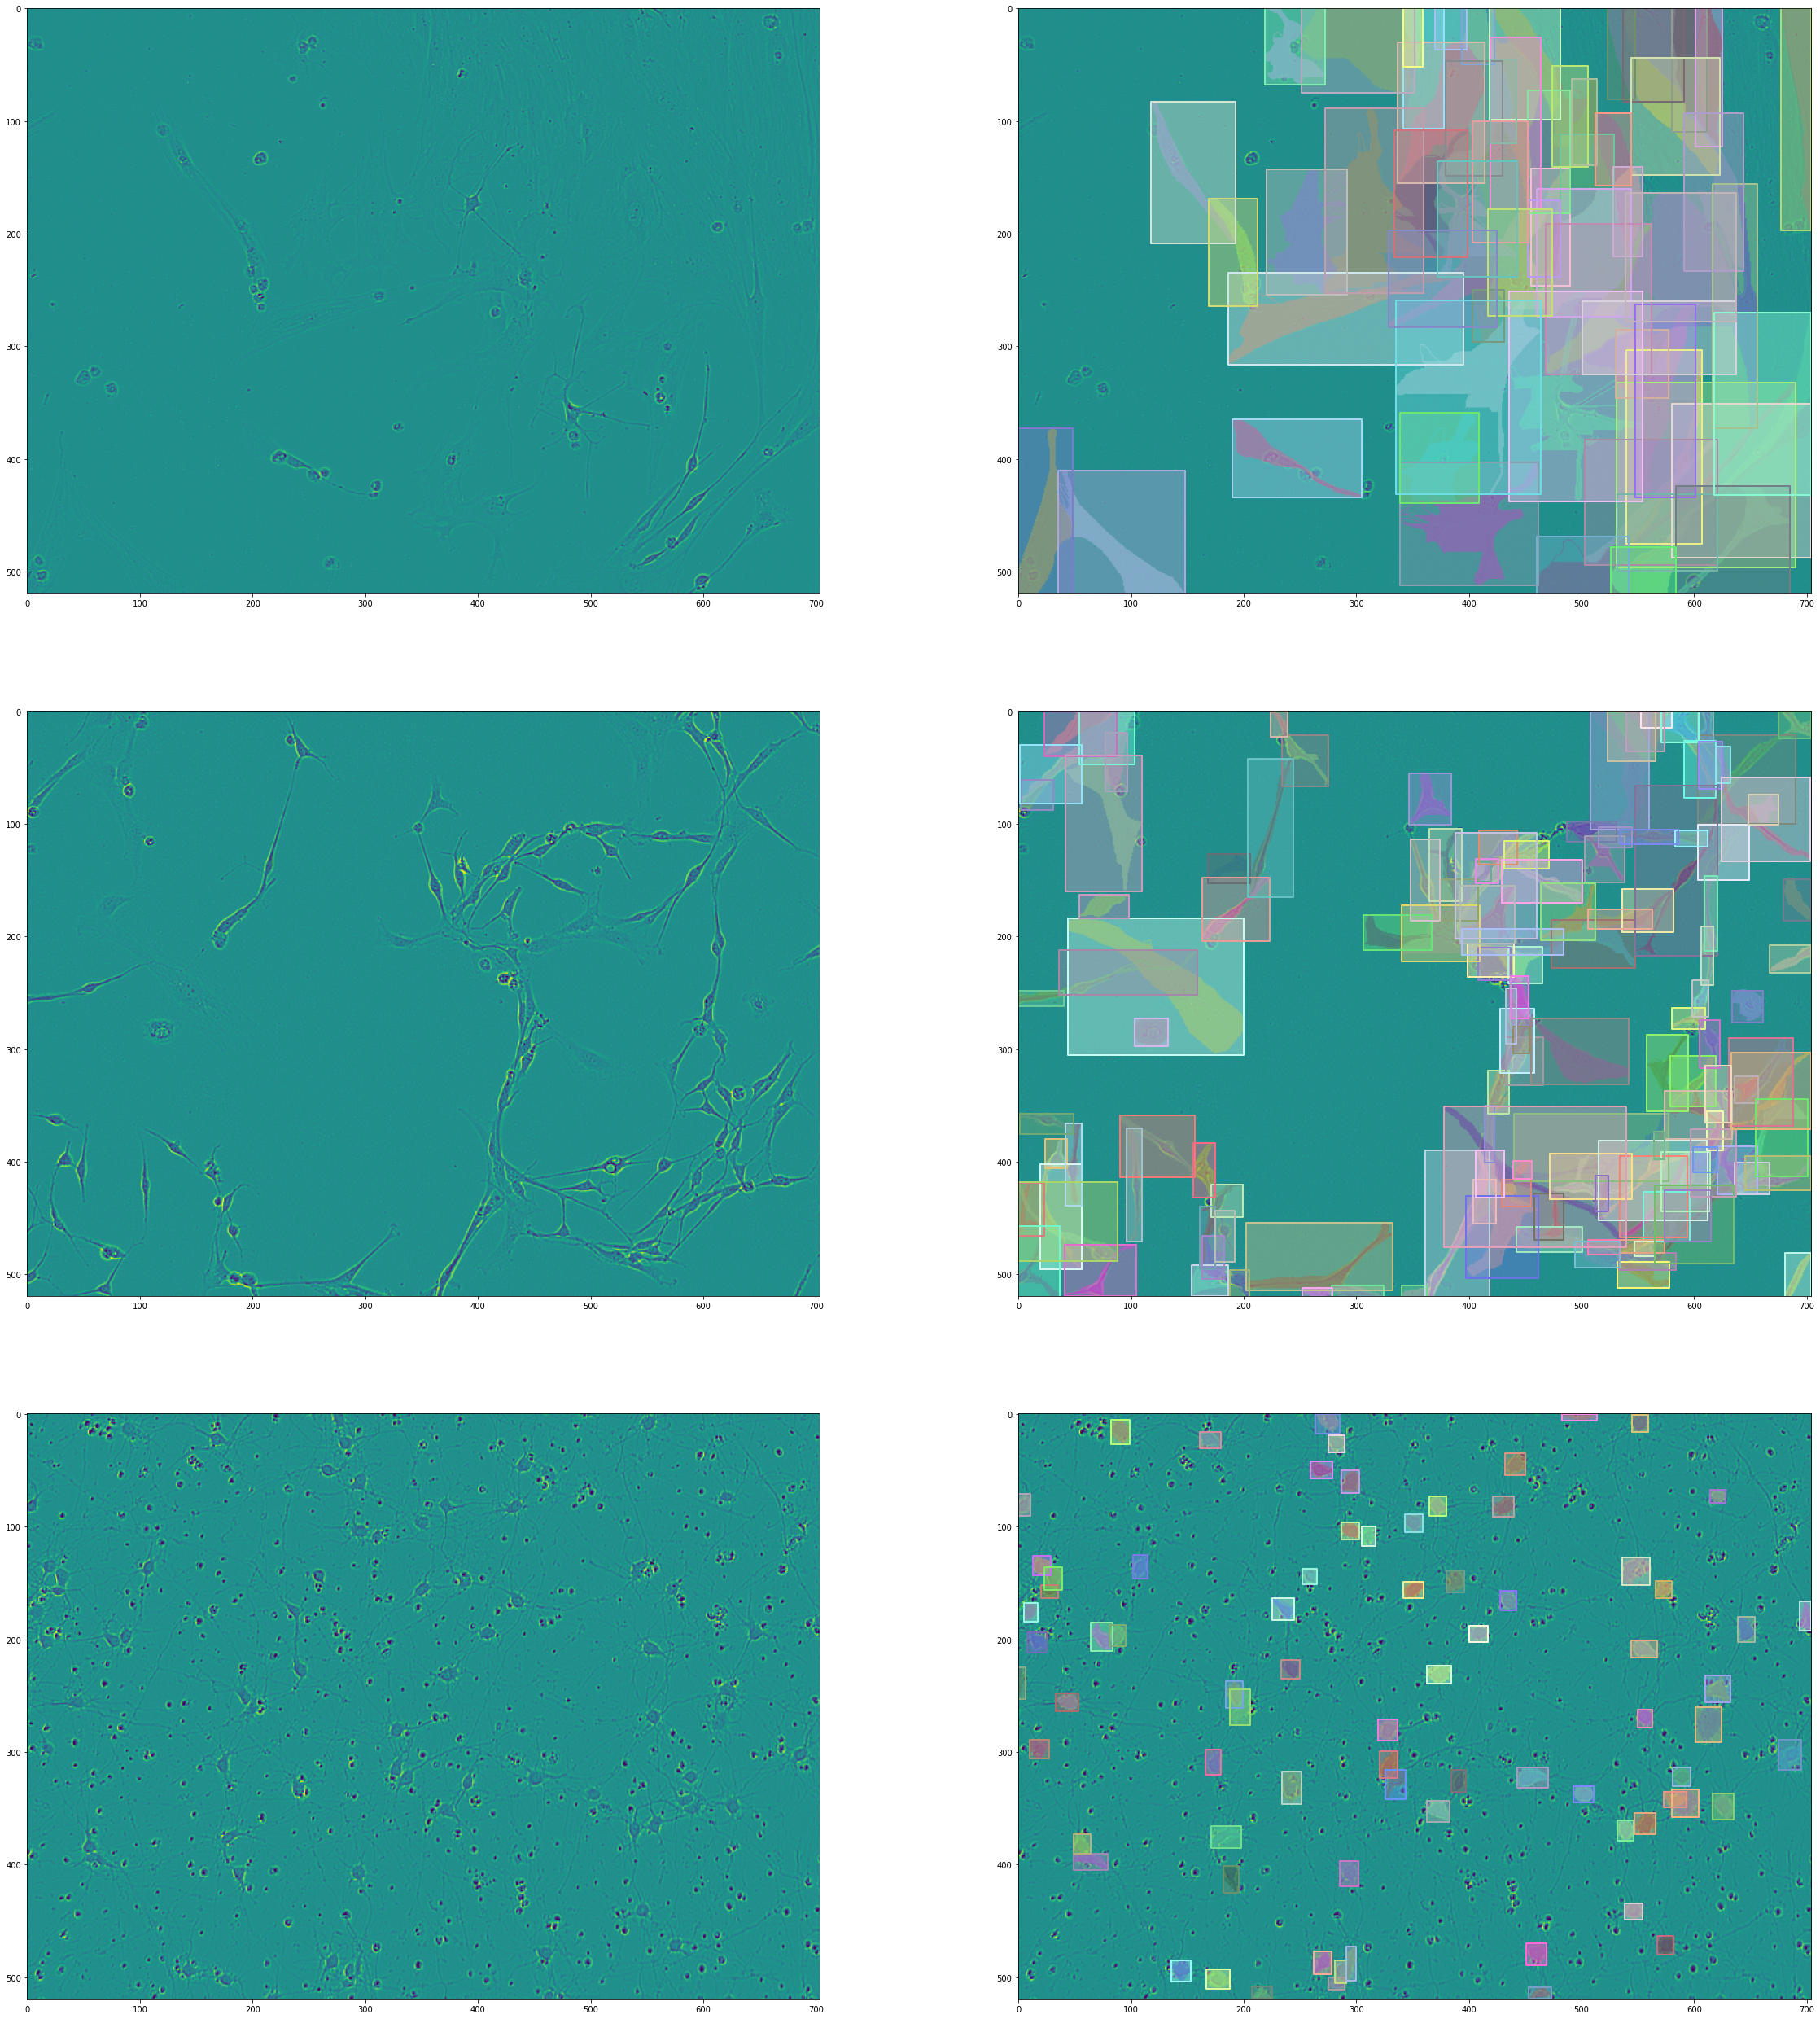

In [8]:
dataDir=Path('sartorius-cell-instance-segmentation')

annFile = Path('sartorius-cell-instance-segmentation-coco/annotations_train.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs), 2, figsize=(40, 15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)